In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import random_split

import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

**1. DATA PREPROCESSING**

We will first load all the images from the [dataset](https://www.kaggle.com/datasets/xainano/handwrittenmathsymbols).

In [2]:
# Load the dataset and make a random rotation
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.RandomRotation(15, fill=255),  # Fill the border with white pixels
    transforms.ToTensor()])
dataset = datasets.ImageFolder("data/data/extracted_images", transform=transform)

Since there are many images we will only use at first a subset of them, with all classes present in both training and testing. For this we use a method found at aux_functions.

In [4]:
from sklearn.model_selection import train_test_split
from aux_functions import get_subset_with_all_labels
from torch.utils.data import Subset

# Get a subset with all labels present
subset = get_subset_with_all_labels(dataset, 2000, 10, True)

# Get labels from the subset
subset_labels = [subset[i][1] for i in range(len(subset))]

# Perform stratified splitting
indices = np.arange(len(subset))
train_indices, test_indices = train_test_split(
    indices, 
    test_size=0.2, 
    stratify=subset_labels,
    random_state=42
)

train_subset = Subset(subset, train_indices)
test_subset = Subset(subset, test_indices)

# Dataloader for training and testing
train_loader = torch.utils.data.DataLoader(train_subset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_subset, batch_size=32, shuffle=True)

Completed label: 0/82
Completed label: 1/82
Completed label: 2/82
Completed label: 3/82
Completed label: 4/82
Completed label: 5/82
Completed label: 6/82
Completed label: 7/82
Completed label: 8/82
Completed label: 9/82
Completed label: 10/82
Completed label: 11/82
Completed label: 12/82
Completed label: 13/82
Completed label: 14/82
Completed label: 15/82
Completed label: 16/82
Completed label: 17/82
Completed label: 18/82
Completed label: 19/82
Completed label: 20/82
Completed label: 21/82
Completed label: 22/82
Completed label: 23/82
Completed label: 24/82
Completed label: 25/82
Completed label: 26/82
Completed label: 27/82
Completed label: 28/82
Completed label: 29/82
Completed label: 30/82
Completed label: 31/82
Completed label: 32/82
Completed label: 33/82
Completed label: 34/82
Completed label: 35/82
Completed label: 36/82
Completed label: 37/82
Completed label: 38/82
Completed label: 39/82
Completed label: 40/82
Completed label: 41/82
Completed label: 42/82
Completed label: 43/8

Now we explore the data checking that it has been correctly preprocessed.

Length of training set: 1600
Length of testing set: 400


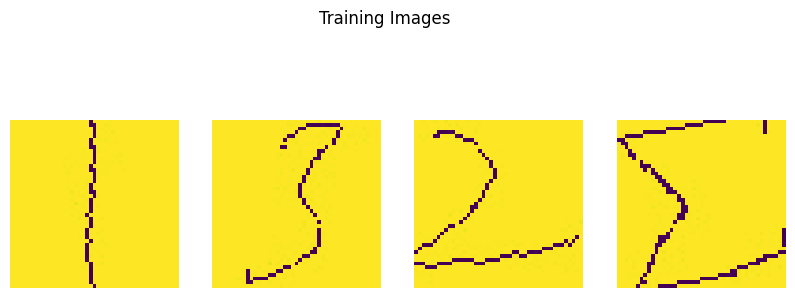

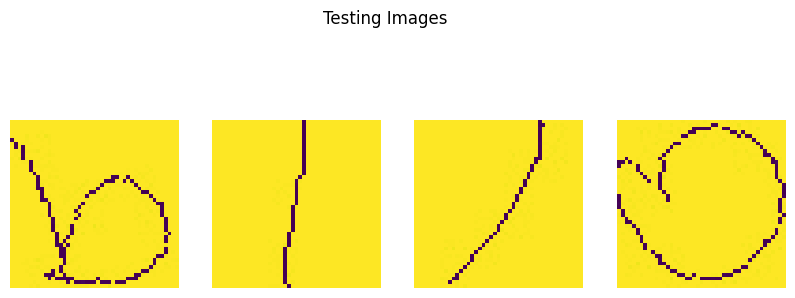

In [10]:
print(f"Length of training set: {len(train_subset)}")
print(f"Length of testing set: {len(test_subset)}")

# Testing data loader
train_images, train_labels = next(iter(train_loader))
test_images, test_labels = next(iter(test_loader))

# Plotting training images
fig1, axes1 = plt.subplots(figsize=(10,4), ncols=4)
for i in range(4):
    ax = axes1[i]
    ax.imshow(train_images[i].permute(1, 2, 0))
    ax.axis("off")
fig1.suptitle("Training Images")
plt.show()

# Plotting testing images
fig2, axes2 = plt.subplots(figsize=(10,4), ncols=4)
for i in range(4):
    ax = axes2[i]
    ax.imshow(test_images[i].permute(1, 2, 0))
    ax.axis("off")
fig2.suptitle("Testing Images")
plt.show()


**2. SIMPLE MODEL CREATION AND TRAINING**

We create a simple CNN at first with 2 convolutional layers and 3 fully connected layers. It will serve as a benchmark to how complex this classification is.

In [11]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.fc1 = nn.Linear(32 * 9 * 9, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 100)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

first_cnn = SimpleCNN().to(device)

Now we will train the model in the subset we created previously

In [12]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(first_cnn.parameters(), lr=0.001)
scaler = torch.cuda.amp.GradScaler()

C:\Users\javie\AppData\Local\Temp\ipykernel_9124\2458281339.py:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


In [ ]:
accumulation_steps = 4

for epoch in range(10):
    first_cnn.train()
    running_loss = 0.0

    for i, (inputs, labels) in enumerate(train_loader, 0):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        with torch.cuda.amp.autocast(): 
            outputs = first_cnn(inputs)
            loss = criterion(outputs, labels) / accumulation_steps

        scaler.scale(loss).backward()

        if (i + 1) % accumulation_steps == 0:  # Update after accumulation
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

        running_loss += loss.item()
        
    print(f"Loss after epoch {epoch+1}: {running_loss}")

print("Finished training")

C:\Users\javie\AppData\Local\Temp\ipykernel_9124\3312443076.py:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Loss after epoch 0: 55.4044189453125
Loss after epoch 1: 53.52923583984375
Loss after epoch 2: 52.87284851074219
Loss after epoch 3: 52.124481201171875
Loss after epoch 4: 51.124717712402344
Loss after epoch 5: 50.02254104614258
Loss after epoch 6: 47.55818843841553
Loss after epoch 7: 44.66558837890625
Loss after epoch 8: 42.13068389892578
Loss after epoch 9: 38.93971252441406
Finished training
